In [16]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import gensim.downloader as api 
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# load dataset

In [2]:
# Load data
books = pd.read_csv("final_dataset_V3.csv")
books = pd.DataFrame(books, columns=['title','genre','summary'])

In [3]:
books

,title,genre,summary
0,Going Wrong,crime,"When he was a young man, Guy Curran led a loc..."
1,The Screwtape Letters,fantasy,"In The Screwtape Letters, C.S. Lewis provides..."
2,King of Foxes,fantasy,"An exceptionally skilled swordsman, young Tal..."
3,If You Could See Me Now,horror,"The novel tells the story of Miles Teagarden,..."
4,Shatter Me,romance,I have a curse\nI have a gift\n\nI am a monste...
...,...,...,...
4995,Soldier's Heart,history,"(Conflict, Rising Action, Climax, Falling Act..."
4996,The Gifts of Imperfection,psychology,In this groundbreaking New York Times best sel...
4997,Talking to Strangers: What We Should Know Abou...,psychology,"Malcolm Gladwell, host of the podcast Revision..."
4998,Why We Sleep: Unlocking the Power of Sleep and...,psychology,Alternate cover edition of ISBN 9781501144318....


# Visualization on genre

In [4]:
books.groupby('genre').count()

,title,summary
genre,,
crime,500,500
fantasy,500,500
history,500,500
horror,500,500
psychology,500,500
romance,500,500
science,500,500
sports,500,500
thriller,500,500


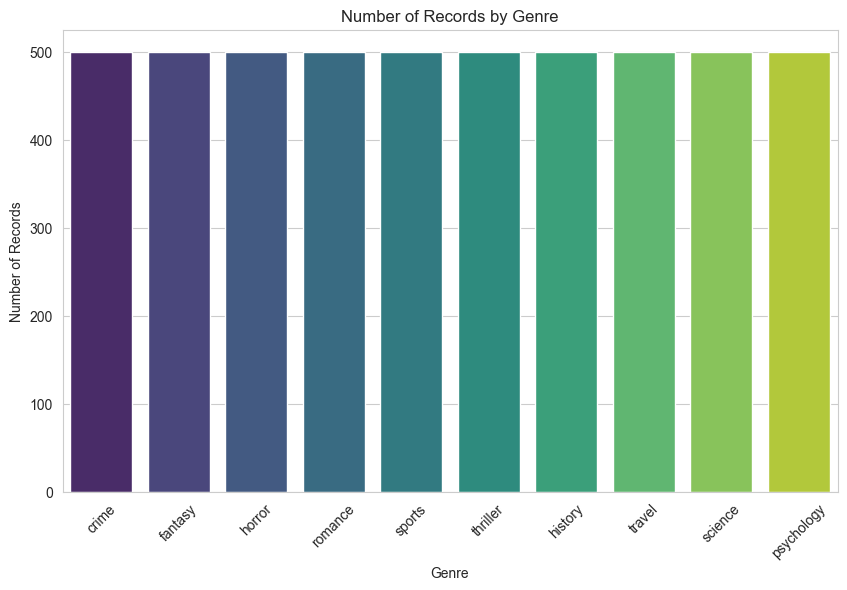

In [7]:
# Convert the dataset into a DataFrame
books = pd.DataFrame(books)

# Count the number of records for each genre
genre_counts = books['genre'].value_counts()

# Plotting
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.xlabel("Genre")
plt.ylabel("Number of Records")
plt.title("Number of Records by Genre")
plt.xticks(rotation=45)
plt.show()


# words Visualization

most common used words in summry.




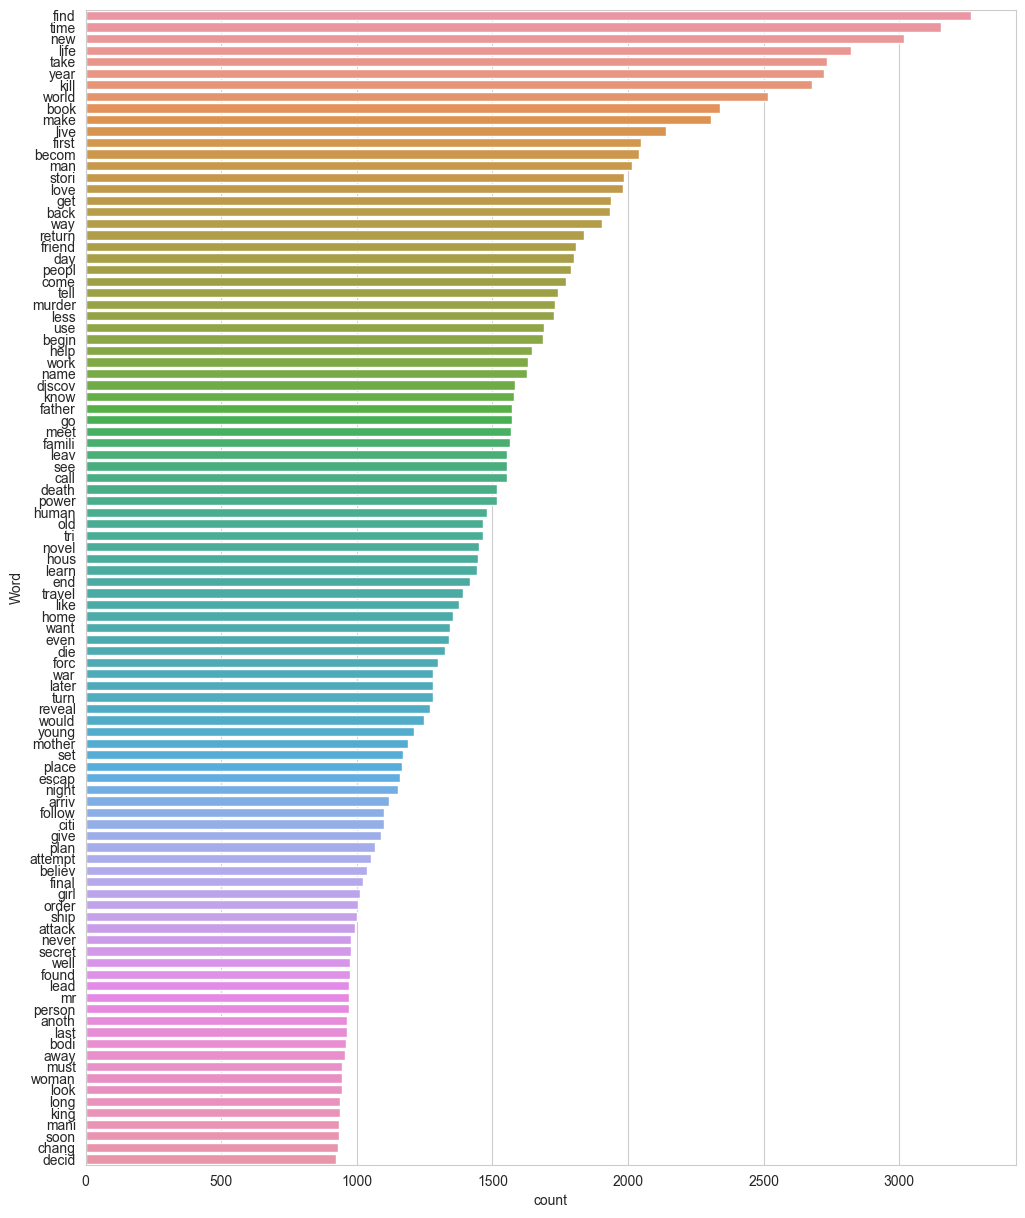

In [25]:
def freqwords(x, terms): 
    print("most common used words in summry.\n\n")
    allwords = ' '.join([text for text in x]) 
    allwords = allwords.split() 
    fdist = nltk.FreqDist(allwords) 
    wordsdf = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    d = wordsdf.nlargest(columns="count", n = terms)  
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

freqwords(books['summary'], 100)

# data preprocessing

## text cleaning

In [9]:
def clean(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

books.loc[:,'summary']=books.loc[:,'summary'].apply(lambda x: clean(x))

In [10]:
books

,title,genre,summary
0,Going Wrong,crime,when he was a young man guy curran led a local...
1,The Screwtape Letters,fantasy,in the screwtape letters c s lewis provides a ...
2,King of Foxes,fantasy,an exceptionally skilled swordsman young tal h...
3,If You Could See Me Now,horror,the novel tells the story of miles teagarden a...
4,Shatter Me,romance,i have a curse i have a gift i am a monster im...
...,...,...,...
4995,Soldier's Heart,history,conflict rising action climax falling action a...
4996,The Gifts of Imperfection,psychology,in this groundbreaking new york times best sel...
4997,Talking to Strangers: What We Should Know Abou...,psychology,malcolm gladwell host of the podcast revisioni...
4998,Why We Sleep: Unlocking the Power of Sleep and...,psychology,alternate cover edition of isbn neuroscientist...


## cleaning

In [11]:
#removing any stopword from the text
def removestopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
    re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
    no_stopword_text = re_stop_words.sub(" ", text)
    return no_stopword_text

books['summary'] = books['summary'].apply(lambda x: removestopwords(x))

In [12]:
books

,title,genre,summary
0,Going Wrong,crime,young man guy curran led local street gan...
1,The Screwtape Letters,fantasy,screwtape letters c lewis provides series ...
2,King of Foxes,fantasy,exceptionally skilled swordsman young tal haw...
3,If You Could See Me Now,horror,novel tells story miles teagarden widowed ...
4,Shatter Me,romance,curse gift monster im human touch ...
...,...,...,...
4995,Soldier's Heart,history,conflict rising action climax falling action ...
4996,The Gifts of Imperfection,psychology,groundbreaking new york times best seller dr...
4997,Talking to Strangers: What We Should Know Abou...,psychology,malcolm gladwell host podcast revisionist hi...
4998,Why We Sleep: Unlocking the Power of Sleep and...,psychology,alternate cover edition isbn neuroscientist ...


## word -> original 

In [14]:
#stem each word
stemmer = PorterStemmer()
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


books['summary'] = books['summary'].apply(lambda x: stemming(x))

In [15]:
books

,title,genre,summary
0,Going Wrong,crime,young man guy curran led local street gang dea...
1,The Screwtape Letters,fantasy,screwtap letter c lewi provid seri lesson impo...
2,King of Foxes,fantasy,except skill swordsman young tal hawkin surviv...
3,If You Could See Me Now,horror,novel tell stori mile teagarden widow english ...
4,Shatter Me,romance,curs gift monster im human touch lethal touch ...
...,...,...,...
4995,Soldier's Heart,history,conflict rise action climax fall action resolu...
4996,The Gifts of Imperfection,psychology,groundbreak new york time best seller dr bren ...
4997,Talking to Strangers: What We Should Know Abou...,psychology,malcolm gladwel host podcast revisionist histo...
4998,Why We Sleep: Unlocking the Power of Sleep and...,psychology,altern cover edit isbn neuroscientist sleep ex...


# Visualization after cleaning

most common used words in summry.




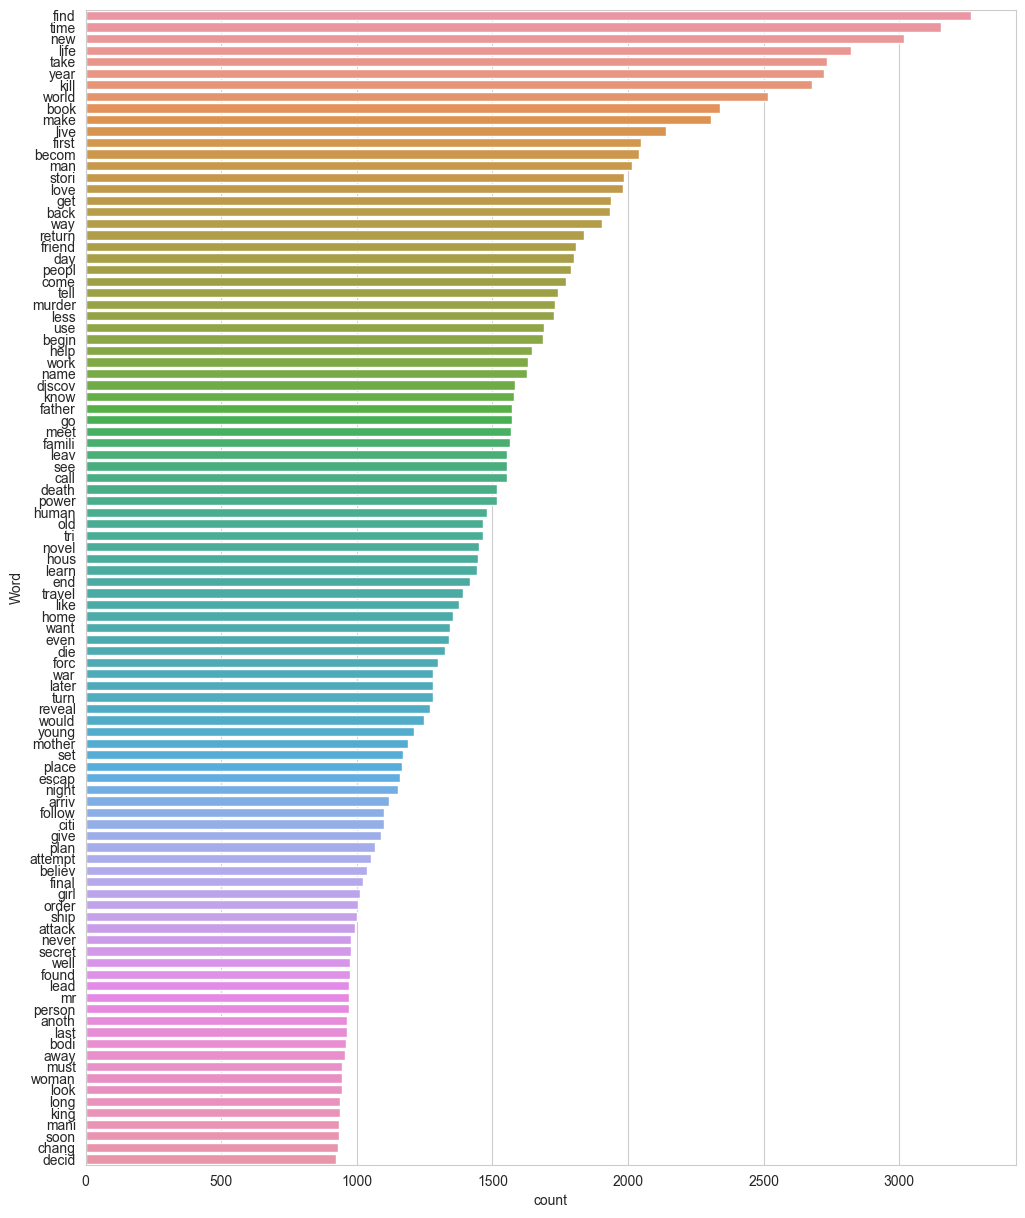

In [26]:
freqwords(books['summary'], 100)

# label encoding

## genre -> number 

In [17]:
# Encoding labels
LE = LabelEncoder()
y = LE.fit_transform(books['genre'])

In [18]:
unique_labels = np.unique(y)
print(unique_labels)

[0 1 2 3 4 5 6 7 8 9]


In [19]:
LE.inverse_transform([0,1,2,3,4,5,6,7,8,9])

array(['crime', 'fantasy', 'history', 'horror', 'psychology', 'romance',
       'science', 'sports', 'thriller', 'travel'], dtype=object)

# Tokenization

## word -> number

In [13]:
# Tokenization and Vectorization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(books['summary'])
X = tokenizer.texts_to_sequences(books['summary'])
X = pad_sequences(X, maxlen=200)

# spliting

In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# load pretrained glove

In [10]:
# Load GloVe embeddings
glove_path = "glove.6B.300d.txt"

## embedding glove model

In [11]:
embedding_dim = 300  
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [14]:
# Create an embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Lstm model



Epoch 1/50


55/55 - 14s - loss: 2.0969 - accuracy: 0.2597 - val_loss: 1.7154 - val_accuracy: 0.4373 - 14s/epoch - 245ms/step
Epoch 2/50
55/55 - 12s - loss: 1.5533 - accuracy: 0.4674 - val_loss: 1.4016 - val_accuracy: 0.4840 - 12s/epoch - 210ms/step
Epoch 3/50
55/55 - 12s - loss: 1.2685 - accuracy: 0.5614 - val_loss: 1.2004 - val_accuracy: 0.5747 - 12s/epoch - 212ms/step
Epoch 4/50
55/55 - 12s - loss: 1.1256 - accuracy: 0.6054 - val_loss: 1.0793 - val_accuracy: 0.6273 - 12s/epoch - 213ms/step
Epoch 5/50
55/55 - 12s - loss: 1.0608 - accuracy: 0.6320 - val_loss: 1.0420 - val_accuracy: 0.6513 - 12s/epoch - 212ms/step
Epoch 6/50
55/55 - 11s - loss: 1.0260 - accuracy: 0.6506 - val_loss: 1.0524 - val_accuracy: 0.6393 - 11s/epoch - 209ms/step
Epoch 7/50
55/55 - 12s - loss: 0.9476 - accuracy: 0.6700 - val_loss: 1.0045 - val_accuracy: 0.6513 - 12s/epoch - 211ms/step
Epoch 8/50
55/55 - 12s - loss: 0.8845 - accuracy: 0.7014 - val_loss: 0.9335 - val_accuracy: 0.6920 - 12s/epoch - 213ms/step
Epoc

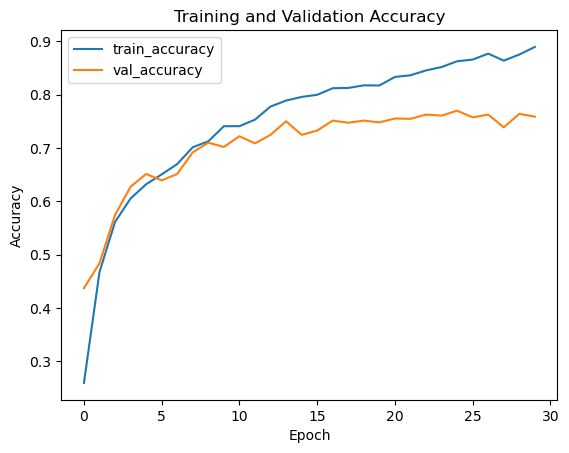

In [6]:
# Model Architecture with Dropout regularization
inputs = Input(shape=(X_train.shape[1],))
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=200, trainable=False)(inputs)
embedding_sequence = SpatialDropout1D(0.25)(embedding_layer)  
lstm_layer = LSTM(64, dropout=0.25, recurrent_dropout=0.25)(embedding_sequence)  
output_layer = Dense(len(np.unique(y)), activation='softmax')(lstm_layer)

model = Model(inputs=inputs, outputs=output_layer)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model Training
history = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# test the model

In [17]:
#load the model
model2=load_model("glove_model.h5")

## prediction 

In [ ]:
# Function to predict genre for a given summary
def predict_genre(summary):
    summary_sequence = tokenizer.texts_to_sequences([summary])
    summary_sequence = pad_sequences(summary_sequence, maxlen=200)
    predicted_probs = model2.predict(summary_sequence)[0]
    predicted_genre_index = np.argmax(predicted_probs)
    predicted_genre = LE.inverse_transform([predicted_genre_index])[0]
    return predicted_genre

In [ ]:
# Variables to count correct and incorrect predictions
correct_predictions = 0
incorrect_predictions = 0

## output prediction

In [9]:
# Predict genres for random books from test data
for _ in range(500):
    idx = random.randint(0, len(X_test) - 1)
    title = books['title'].iloc[idx]
    summary = books['summary'].iloc[idx]
    predicted_genre = predict_genre(summary)
    actual_genre = books['genre'].iloc[idx]
    
    print("\nBook:", title)
    print("Predicted Genre:", predicted_genre)
    print("Actual Genre:", actual_genre)
    
    # Check if prediction is correct
    if predicted_genre == actual_genre:
        correct_predictions += 1
    else:
        incorrect_predictions += 1

# Print counts of correct and incorrect predictions
print("\nNumber of Correct Predictions:", correct_predictions)
print("Number of Incorrect Predictions:", incorrect_predictions)

1/1 [==============================] - 0s 243ms/step

Book: Country of the Blind
Predicted Genre: crime
Actual Genre: crime
1/1 [==============================] - 0s 22ms/step

Book: Special Assignments: The Further Adventures of Erast Fandorin
Predicted Genre: crime
Actual Genre: crime
1/1 [==============================] - 0s 22ms/step

Book: The Girl in the Ice
Predicted Genre: thriller
Actual Genre: thriller
1/1 [==============================] - 0s 22ms/step

Book: The Outlaws of Mars
Predicted Genre: science
Actual Genre: science
1/1 [==============================] - 0s 25ms/step

Book: Odd Thomas
Predicted Genre: horror
Actual Genre: horror
1/1 [==============================] - 0s 23ms/step

Book: Deception Point
Predicted Genre: thriller
Actual Genre: thriller
1/1 [==============================] - 0s 22ms/step

Book: Contact
Predicted Genre: science
Actual Genre: science
1/1 [==============================] - 0s 22ms/step

Book: The Baller
Predicted Genre: sports
Actual Genr

# visualization for the model

## Confusion Matrix


47/47 [==============================] - 1s 17ms/step


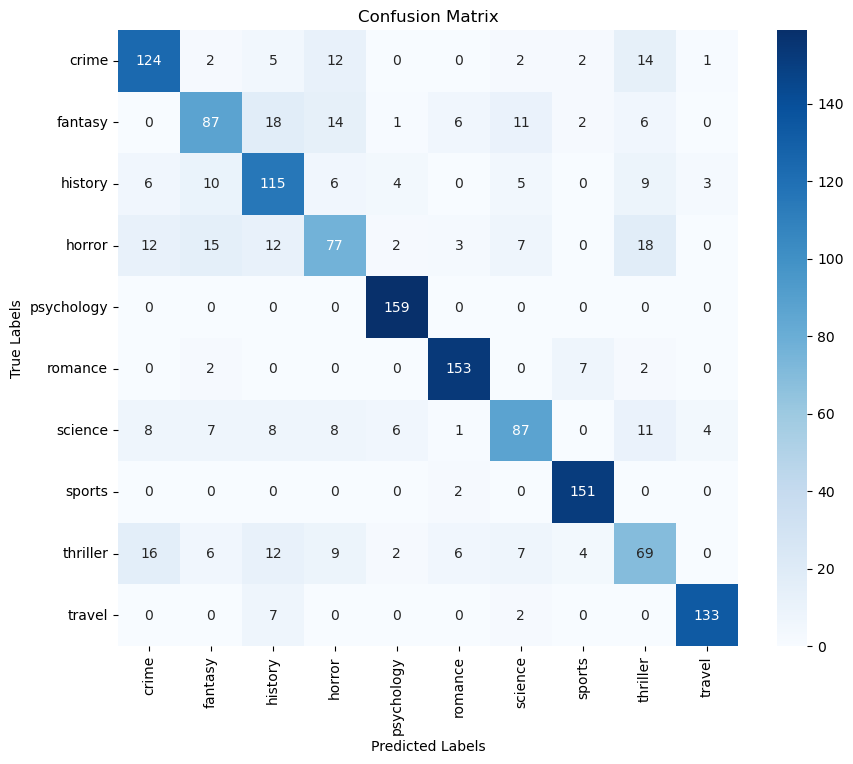

In [10]:
# Confusion Matrix
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LE.classes_, yticklabels=LE.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Classification Report


In [11]:
# Classification Report
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=LE.classes_))

47/47 [==============================] - 1s 16ms/step
Classification Report:
              precision    recall  f1-score   support

       crime       0.75      0.77      0.76       162
     fantasy       0.67      0.60      0.64       145
     history       0.65      0.73      0.69       158
      horror       0.61      0.53      0.57       146
  psychology       0.91      1.00      0.95       159
     romance       0.89      0.93      0.91       164
     science       0.72      0.62      0.67       140
      sports       0.91      0.99      0.95       153
    thriller       0.53      0.53      0.53       131
      travel       0.94      0.94      0.94       142

    accuracy                           0.77      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.76      0.77      0.77      1500

